In [1]:
import sys
sys.path.append("..")
import numpy as np
data = np.load("../data/parchments.npz")
spectrums = data['x']
labels = data['labels']

## Looking at the spectra

Text(0.5, 1.0, 'A')

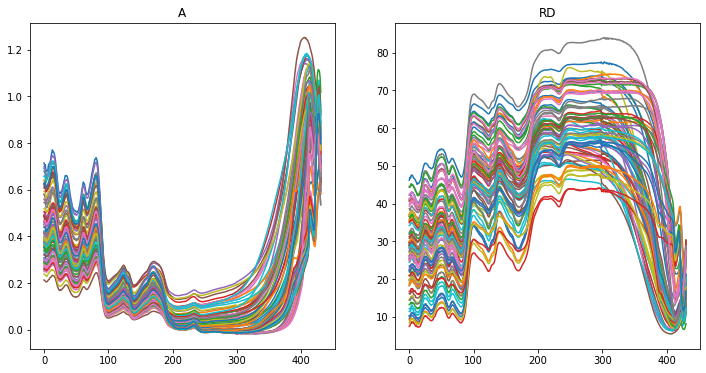

In [2]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 6))
for i in range(spectrums.shape[0]):
    ax1.plot(spectrums[i, 0, ::5])
for i in range(spectrums.shape[0]):
    ax2.plot(spectrums[i, 1, ::5])
ax2.set_title("RD")
ax1.set_title("A")

## Defining the Neural Network: The auto encoder architecture

In [3]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, in_features, out_features):
        super(Encoder, self).__init__()
        self.l1 = nn.Linear(in_features, 256)
        self.l2 = nn.Linear(256, 64)
        self.l3 = nn.Linear(64, out_features)
    def forward(self, X):
        X = torch.tanh(self.l1(X))
        X = torch.relu(self.l2(X))
        X = torch.tanh(self.l3(X))
        return X

class Decoder(nn.Module):
    def __init__(self, in_features, out_features):
        super(Decoder, self).__init__()
        self.l1 = nn.Linear(in_features, 64)
        self.l2 = nn.Linear(64, 256)
        self.l3 = nn.Linear(256, out_features)

    def forward(self, X):
        X = torch.tanh(self.l1(X))
        X = torch.relu(self.l2(X))
        X = torch.tanh(self.l3(X))
        return X

class AutoEncoder(nn.Module):
    def __init__(self, features, latent_features=2, variationnal=False, smoothing=15):
        super(AutoEncoder, self).__init__()
        if variationnal:
            self.enc = Encoder(features, latent_features*2)
            self.dec = Decoder(latent_features, features+smoothing-1)
        else:
            self.enc = Encoder(features, latent_features)
            self.dec = Decoder(latent_features, features+smoothing-1)

        self.latent_features = latent_features
        self.variationnal = variationnal
        self.smoothing = smoothing
        self.c1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=self.smoothing)
    def forward(self, X):
        bs = X.shape[0]
        if self.variationnal:
            X = self.enc(X).view(-1, 2, self.latent_features)
            mu = X[:, 0, :]
            logvar = (X[:, 1, :] - 1) * 5
            X = self.reparameterize(mu, logvar)
            return self.c1(self.dec(X).view(bs, 1, -1)).view(bs, -1), mu, logvar
        else:
            return self.c1(self.dec(self.enc(X)).view(bs, 1, -1)).view(bs, -1)
    
    def reconstruct(self, X):
        bs = X.shape[0]
        recons = self.dec(X).view(bs, 1, -1)
        recons = self.c1(recons)
        return (recons.view(bs, -1))
    
    def encode(self, X, std=False):
        code = self.enc(X)
        if self.variationnal:
            view = code.view(-1, 2, self.latent_features)
            if std:
                return view[:, 0, :], view[:, 1, :]
            else:
                return view[:, 0, :]
        else:
            return self.enc(X)

    def reparameterize(self, latent_mean, latent_logvar):
        std = torch.exp(0.5*latent_logvar)
        eps = torch.randn_like(std)
        sample = latent_mean + (eps * std)
        return sample

## Rescaling the data in the range 0.0, 1.0

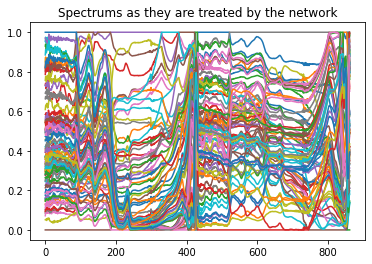

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
x = spectrums[:,:, ::5]
xs = scaler.fit_transform(x.reshape(x.shape[0], -1))
import matplotlib.pyplot as plt
for i in range(spectrums.shape[0]):
    plt.plot(xs[i, :])
plt.title("Spectrums as they are treated by the network")
from torch.utils.data import TensorDataset, DataLoader
loader = DataLoader(TensorDataset(torch.from_numpy(xs).type(torch.float)), batch_size=4, shuffle=True)

## Training the model on the dataset

In [9]:
mse_loss = nn.MSELoss()
ae = AutoEncoder(xs.shape[1], 2, variationnal=True, smoothing=15)
from torch.optim import Adam
optim = Adam(ae.parameters(), lr=1e-3, weight_decay=1e-5)
num_epochs = 100
from tqdm import trange
progress_bar = trange(num_epochs)
for epoch in progress_bar:
    epoch_loss = 0.0
    for X, in loader:
        optim.zero_grad()
        Xp, mu, logvar = ae(X)
        recons_loss = mse_loss(Xp, X)
        kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        (recons_loss+kld_loss*1e-6).backward()
        optim.step()

        epoch_loss += recons_loss.item()
    epoch_loss /= len(loader)
    progress_bar.set_description_str(f"{epoch_loss}")
    

0.004463592799203027: 100%|████████████████████████| 100/100 [00:20<00:00,  4.86it/s]


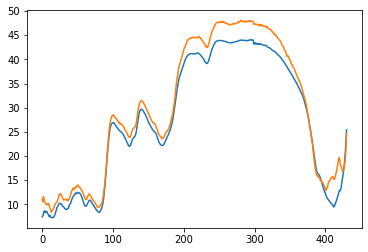

In [10]:
plt.plot(scaler.inverse_transform(X[0].detach().numpy()[np.newaxis, :]).reshape(2, -1)[1])
plt.plot(scaler.inverse_transform(Xp[0].detach().numpy()[np.newaxis, :]).reshape(2, -1)[1])

## Visualization of the latent space

(81, 4)


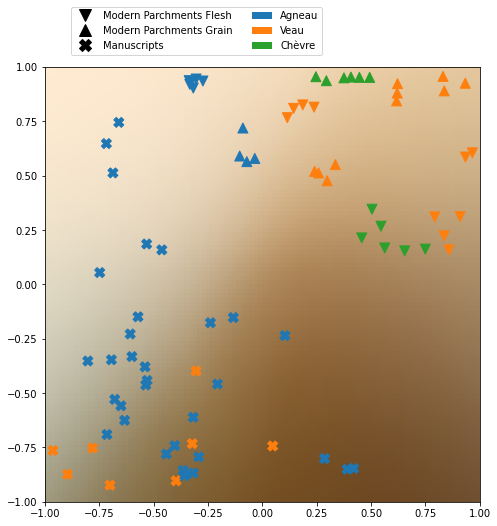

In [11]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
latent = ae.encode(torch.from_numpy(xs).type(torch.float)).detach().numpy()
print(labels.shape)
markers = ["v", "^", "X"]
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow((np.load("../data/colorimetry.npy")), extent=[-1, 1, -1, 1])
markerlabel = np.array([ a * 10 + b for a, b in zip( labels[:, 2], labels[:, 3])])
for i, c in enumerate(np.unique(markerlabel)):
    mask = markerlabel == c
    cur = latent[mask,:]
    ax.scatter(*cur.T, c=[f"C{l}" for l in labels[mask, 0].flat], marker=markers[i], s=100)
legend_elements = [Line2D([0], [0], marker="v", markersize=12, color='k', linestyle="", label='Modern Parchments Flesh'),
                   Line2D([0], [0], marker="^", markersize=12, color='k', linestyle="", label='Modern Parchments Grain'),
                   Line2D([0], [0], marker='X', color='k', linestyle="", label='Manuscripts', markersize=12),
                   Patch(facecolor='C0',  label='Agneau'),
                   Patch(facecolor='C1',  label='Veau'),
                   Patch(facecolor='C2',  label='Chèvre'),
                   ]
                
plt.axis("square")
plt.axis([-1, 1, -1, 1])
plt.legend(handles=legend_elements, bbox_to_anchor =(0.65, 1.15), ncol=2)

In [13]:
torch.save(ae.state_dict(), "vae_05.model")
import pickle
pickle.dump(scaler, open("vae_05.scaler", "wb"))

## Not used here

In [398]:
import shap
batch = next(iter(loader))
spectras, = batch
e = shap.DeepExplainer(ae.enc, spectras)
shap_values = e.shap_values(spectras[0:1])

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


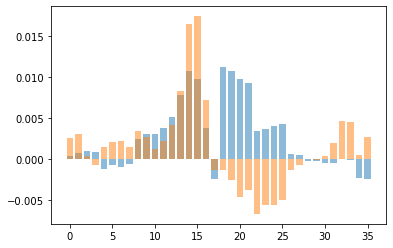

In [408]:
fig, axs = plt.subplots()
for i in range(len(shap_values)//2):
    data = shap_values[i][0][::3].reshape(-1, 8).sum(-1)
    axs.bar(np.arange(len(data)), data, alpha=0.5)

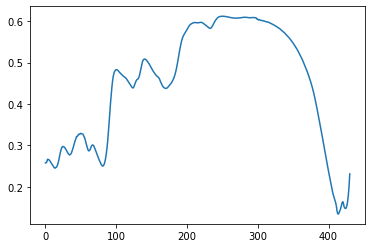

In [407]:
plt.plot(scaler.inverse_transform(spectras).reshape(spectras.shape[0], 2, -1)[0,1])

1.0

-0.8356485778558536